In [20]:
using CSV; using DataFrames; using Dierckx;
using DifferentialEquations;
data = CSV.read("example_data.csv", DataFrame)

,glucose0,glucose30,glucose60,glucose90,glucose120,insulin0,insulin30,insulin60
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5.0,7.5,7.9,6.5,5.8,8.58,55.7,71.2
2,5.9,8.45,8.15,7.3,5.25,11.65,59.4,99.0
3,5.0,8.6,10.1,9.7,8.6,11.5,59.0,73.2
4,5.9,9.6,11.4,10.9,9.6,10.9,48.5,70.9
5,6.5,10.0,12.9,13.0,12.0,15.4,48.3,78.9
6,6.9,17.4,15.2,17.7,15.2,6.99,38.2,62.4
7,4.2,3.8,5.6,4.2,2.6,4.74,58.1,52.5


In [15]:
using Pkg
Pkg.add("DifferentialEquations")

    Updating registry at `C:\Users\pavan\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\pavan\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\pavan\.julia\environments\v1.7\Manifest.toml`


In [5]:
p = [   1.35e-2  #k1
    6.33e-1  #k2
    5.00e-5  #k3
    1.00e-3  #k4
    3.80e-3  #k5
    5.82e-1  #k6
    2.20e-2  #k7
    4.71     #k8
    1.08e-2  #k9
    2.60     #k10
    1.35     #sigma /index 11
    0.63     #Km /index 12
    data[1,1]     #Gb /index 13
    data[1,6]];     #Iplb /index 14 

In [62]:
c = Dict("f"=> 0.00551,"vg" => 17/70, "gbliv" => 0.043, "beta" => 1, "taui"=>31, "taud"=>3, "vi"=> 13/70, "Gthpl"=> 9,
"t_integralwindow" =>30, "c1"=> 0.1,"c3" => p[7]*p[13]/1*31*p[14]*30)

merge!(c, Dict("c2"=> 0.043*(p[12]+p[13])/p[13]-p[5]*c["beta"]*p[14]))

#c = (f= 0.00551,vg = 17/70, gbliv = 0.043, beta = 1, taui=31, taud=3, vi= 13/70, Gthpl= 9, t_integralwindow =30, 
#c1= 0.1,c2= 0.043*(p[12]+p[13])/p[13]-p[5]*c.beta*p[14], c3 = p[7]*p[13]/1*31*p[14]*30)



Dict{String, Real} with 12 entries:
  "f"                => 0.00551
  "c1"               => 0.1
  "Gthpl"            => 9
  "gbliv"            => 0.043
  "taud"             => 3
  "t_integralwindow" => 30
  "vg"               => 0.242857
  "c2"               => 0.015814
  "taui"             => 31
  "beta"             => 1
  "vi"               => 0.185714
  "c3"               => 877.734

In [6]:
sim_Gpl= p[13];
sim_Ipl= p[14];

In [7]:
sim_MG=0
sim_Gint=0;
data_meal= 75e3; #in milligrams
meal_start_time=0;
bodymass= 70; # in kg
timespan = range(0,120,121);
time_intervals = [0,30,60,90,120]
p_values= zeros(length(data[!,1]),4)
residuals= zeros(length(data[!,1]),10)
sim_glu= zeros(length(data[!,1]),121);
sim_ins= zeros(length(data[!,1]),121);

In [11]:
t_saved=0;
Gpl_saved= sim_Gpl;

p0= [0.013511373352062 0.003806228136097 0.583886959936111 4.724211331206339]; #initial parameter values for optimization

namP= [1,5,6,8]; # choice of parameters to estimate based on data
lbP= p0*0.001; #lower bound of parameter set (contraining)
hbP= p0*1000;  # upper bound of the parameter set (constraining)

In [162]:
p[1]=0.0157
p[5]=0.0045
p[6]=5.4142
p[8]=51.8944

51.8944

In [12]:
x0=[sim_MG, sim_Gpl, sim_Ipl, sim_Gint];
input=Dict("D"=>data_meal,"t_meal_start"=>meal_start_time,"Mb"=>bodymass);

In [149]:
t_saved=[0]
Gpl_saved=[4.2]
a=collect(1:120);

In [208]:
function differentialequations(du,u,p,t)
    #All parameters used
    sigma,k1,D,k2,meal_start_time, gbliv,k3,Gb,k4,beta,Iplb,Mb,KM,k5,vg,f,c2,c1,Gthpl,t_integralwindow,k6,k7,taui,taud,k8,c3,k9= p
   
    #Glucose in gut
    #u[1] represents Mg
    if t > meal_start_time
        mgmeal = sigma.*k1.^sigma.*(t-meal_start_time).^(sigma-1) .* exp(-(k1.*(t-meal_start_time)).^sigma) .* D;
    else
        mgmeal=0;
    end

    mgpl    = k2.*u[1];
    du[1] = mgmeal - mgpl; #dMg/dt

    # Glucose in plasma
    #u[2] represents Gpl
    gliv= gbliv- k3.*(u[2]-Gb) - k4.*beta.*(u[3]-Iplb);
    ggut    = k2 .*(f/(vg*Mb)) .* u[1];
    gnonit  = c2 .* (u[2]./(KM+u[2]));
    git     = k5.*beta.*u[3] .* (u[2]./(KM+u[2]));
    if u[2] > Gthpl
        gren  = c1./(vg*Mb) .* (u[2] - Gthpl);
    else
        gren = 0;
    end

    du[2] = gliv + ggut - gnonit - git - gren;  # dGpl/dt
    
    #Insulin in plasma
    #u[3] represents Ipl
    #u[4] represents Gint
    t_lowerbound= t- t_integralwindow;

    if (t > t_integralwindow) && (length(t_saved)>1) && (length(t_saved) == length(Gpl_saved))
        spl=Spline1D(t_saved,Gpl_saved)
        Gpl_lowerbound= spl(t_lowerbound);
    else
        Gpl_lowerbound = Gpl_saved[1];  #is called when t < t_integralwindow, or if there is no saved step yet (steps are only saved at pre-defined time points)
    end
    #Gpl_lowerbound = interp1(t_saved,Gpl_saved,t_lowerbound, 'spline');
    du[4] = (u[2]-Gb) - (Gpl_lowerbound-Gb); #dGint/dt
    ipnc    = (beta.^-1).*(k6.*(u[2]-Gb) + (k7/taui).*u[4]+ (k7/taui).*Gb.*t_integralwindow + (k8.*taud).*du[2]);
    
    #iliv & iif
    iliv    = c3.*u[3];
    iif     = k9.*(u[3]-Iplb);
    
    du[3] = ipnc - iliv - iif; #dIpl/dt
    

end

differentialequations (generic function with 1 method)

In [209]:
param= (p[11],p[1],data_meal,p[2],0,c["gbliv"],p[3],p[13],p[4],c["beta"],p[14],bodymass,p[12],p[5],c["vg"],c["f"],c["c2"],c["c1"],c["Gthpl"],c["t_integralwindow"], p[6],p[7],c["taui"],c["taud"],p[8],c["c3"],p[9]);

In [185]:
t_saved=[]
push!(t_saved,1)

1-element Vector{Any}:
 1

In [219]:
u0=[0,5.0,8.5,0]
a= collect(0:119)
t=0
t_saved=[0]
Gpl_saved=[5.0]
Insulin_saved=[8.5]
sol=[]
final_sol=[]
while t in a
    tspan=(t, t+1)

    prob = ODEProblem(differentialequations,u0,tspan,param)
    sol=solve(prob, Tsit5())
    t=t+1
    push!(t_saved,t)
    push!(Gpl_saved, last(sol[2,:]))
    push!(Insulin_saved,last(sol[3,:]))
    u0=last(sol)
    
    
end


In [212]:
sol[1]

4-element Vector{Float64}:
 317.21716762218847
  24.61018254525349
   0.12305772162696342
 576.4176142508488

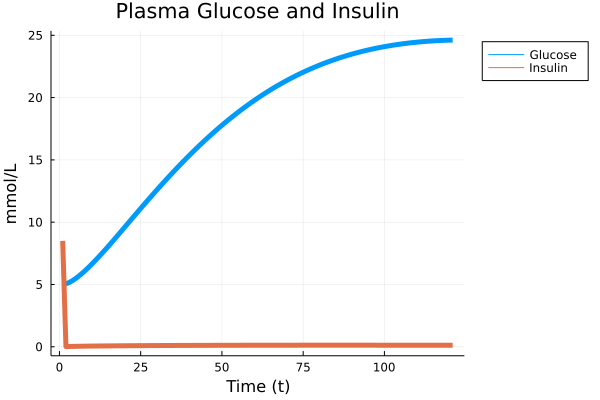

In [223]:
glu=sol[2,:]
ins= sol[3,:]
using Plots
plot(Gpl_saved,linewidth=5,title="Solution to the linear ODE",
xaxis="Time (t)",yaxis="mmol/L",label="Glucose", legend= :outertopright) 
plot!(Insulin_saved,linewidth=5,title="Plasma Glucose and Insulin",
xaxis="Time (t)",yaxis="mmol/L",label="Insulin")


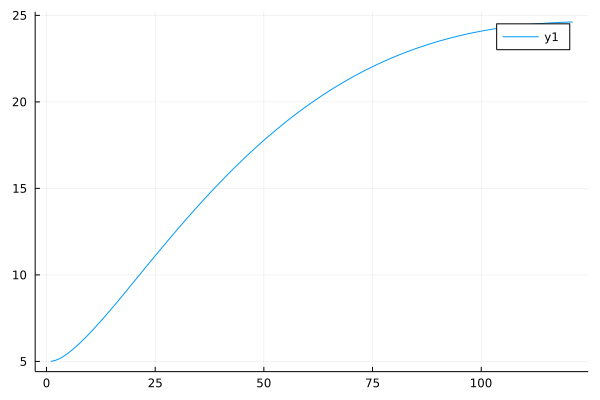

In [211]:
plot(Gpl_saved)